# Python実践データ分析 100本ノック  
## 第7章

### ノック61

In [26]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

df_tc = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/demand.csv")
df_supply = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/supply.csv")

np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))
m1 = model_min()
v1 = {(i, j):LpVariable("v%d_%d"%(i, j), lowBound=0) for i, j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i, j] for i, j in pr)

for i in range(nw):
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i,j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
print(df_tr_sol)
print("総輸送コスト："+str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト：1296.0


### ノック62

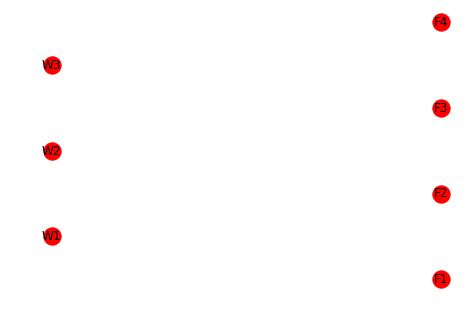

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv("../sample_100knocks/サンプルコード_20200325/6章/trans_route.csv", index_col="工場")
df_pos = pd.read_csv("../sample_100knocks/サンプルコード_20200325/6章/trans_route_pos.csv")

G = nx.Graph()

for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

nx.draw(G, pos, with_labels=True)
plt.show()

In [29]:
size = 0.1
edge_weights = []
for i in range(len(df_tr_sol)):
    for j in range(len(df_tr_sol.columns)):
        edge_weights.append(df_tr_sol.iloc[i][j]*size)
edge_weights

[2.8000000000000003,
 0.7000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 3.1,
 0.5,
 0.0,
 2.2,
 0.0,
 2.0]

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


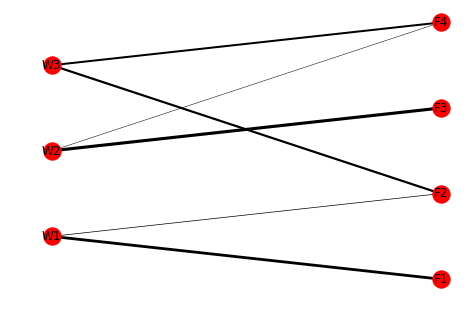

In [31]:
for i in range(len(df_tr_sol.index)):
    for j in range(len(df_tr_sol.columns)):
        G.add_edge(df_tr_sol.index[i], df_tr_sol.columns[j])
nx.draw(G, pos, with_labels=True, width=edge_weights)
plt.show()

### ノック63

In [32]:
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if temp_sum >= df_demand.iloc[0][i]:
            flag[i] = 1
    return flag

def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag 

print("需要条件 確認結果：" + str(condition_demand(df_tr_sol, df_demand)))
print("供給条件 確認結果：" + str(condition_supply(df_tr_sol, df_supply)))

需要条件 確認結果：[1. 1. 1. 1.]
供給条件 確認結果：[1. 1. 1.]


### ノック64

In [33]:
df_material = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/product_plan_material.csv", index_col="製品")
df_profit = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/product_plan_profit.csv", index_col="製品")
df_stock = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/product_plan_stock.csv", index_col="項目")
df_plan = pd.read_csv("../sample_100knocks/サンプルコード_20200325/7章/product_plan.csv", index_col="製品")

In [34]:
df_material

,原料1,原料2,原料3
製品,,,
製品1,1,4,3
製品2,2,4,1


In [35]:
df_profit

,利益
製品,
製品1,5.0
製品2,4.0


In [36]:
df_stock

,原料1,原料2,原料3
項目,,,
在庫,40,80,50


In [37]:
df_plan

,生産量
製品,
製品1,16
製品2,0


### ノック65

In [46]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        profit += df_profit.iloc[i][0] * df_plan.iloc[i][0]
    return profit

In [47]:
print("総利益：" + str(product_plan(df_profit, df_plan)))

総利益：80.0


### ノック66

In [49]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

m1 = model_max()
v1 = {(i):LpVariable("v%d"%(i), lowBound=0) for i in range(len(df_profit))}

m1 += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

for i in range(len(df_material.columns)):
    m1 += lpSum(df_material.iloc[j, i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m1.solve()

1

In [56]:
df_plan_sol = df_plan.copy()
for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益：" + str(product_plan(df_profit, df_plan_sol)))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益：95.0


### ノック67

In [92]:
def condition_chk(df_plan, df_stock, df_material):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        use_sum = 0
        for j in range(len(df_material.index)):
            use_sum += df_plan.iloc[j][0] * df_material.iloc[j][i] 
        print(str(df_material.columns[i]) + " 使用量:" + str(use_sum) + " 在庫:" + str(df_stock.iloc[0][i]))
        
        if (use_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
    return flag

In [93]:
print("制約条件計算結果:" + str(condition_chk(df_plan_sol, df_stock, df_material)))

原料1 使用量:25.0 在庫:40
原料2 使用量:80.0 在庫:80
原料3 使用量:50.0 在庫:50
制約条件計算結果:[1. 1. 1.]


### ノック68

In [101]:
製品 = list("AB")
需要地 = list("PQ")
工場 = list("XY")
レーン = (2, 2)

tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=["需要地", "工場"])
tbdi["輸送費"] = [1,2,3,1]
print(tbdi)

tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=["需要地", "製品"])
tbde["需要"] = [10,10,20,20]
print(tbde)

tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (工場, レーン) for l in range(nl) for i in 製品), columns=["工場","レーン","製品","下限","上限"])
tbfa["生産費"] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,"上限"] = 10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ =logistics_network(tbde, tbdi, tbfa)
print(tbfa)
print(tbdi2)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


### ノック69

In [102]:
print(tbdi2)

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


In [112]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2.iloc[i][2] * tbdi2.iloc[i][5]
print("総輸送コスト"+str(trans_cost))

総輸送コスト80.0


### ノック70

In [113]:
print(tbfa)

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0


In [117]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i] * tbfa["ValY"].iloc[i]
print("総生産コスト"+str(product_cost))

総生産コスト120.0
